## **Bibliotecas Utilizadas**


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import string
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import time

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

STOPWORDS = nltk.corpus.stopwords.words('portuguese') 
SEED = 42

## **Características da base**

In [2]:
df_train = pd.read_excel('train.xlsx',usecols=[1,2])
df_test = pd.read_excel('test.xlsx', usecols=[1,2])
from sklearn.model_selection import train_test_split
train,test= train_test_split(df_train,test_size=0.3)

print('Proporções treinamento = {}'.format(df_train.shape))
print('Tamanho em memória treinamento = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Proporções teste= {}'.format(df_test.shape))
print('Tamanho em memória teste= {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
train.head(5)

Proporções treinamento = (7500, 2)
Tamanho em memória treinamento = 0.11 MB
Proporções teste= (3215, 2)
Tamanho em memória teste= 0.05 MB


,Text,Classificacao
198,Com o objetivo de reprimir o tráfico de drogas...,Positivo
7335,Polícia em MG apresenta rapaz que recebia drog...,Positivo
2778,RT @Nonato55557777: Mesmo em calamidade financ...,Negativo
1758,Polícia prende nove suspeitos de tráfico de dr...,Positivo
5912,"Me integro al mame.��\r\n\r\nEl juego es así, ...",Neutro


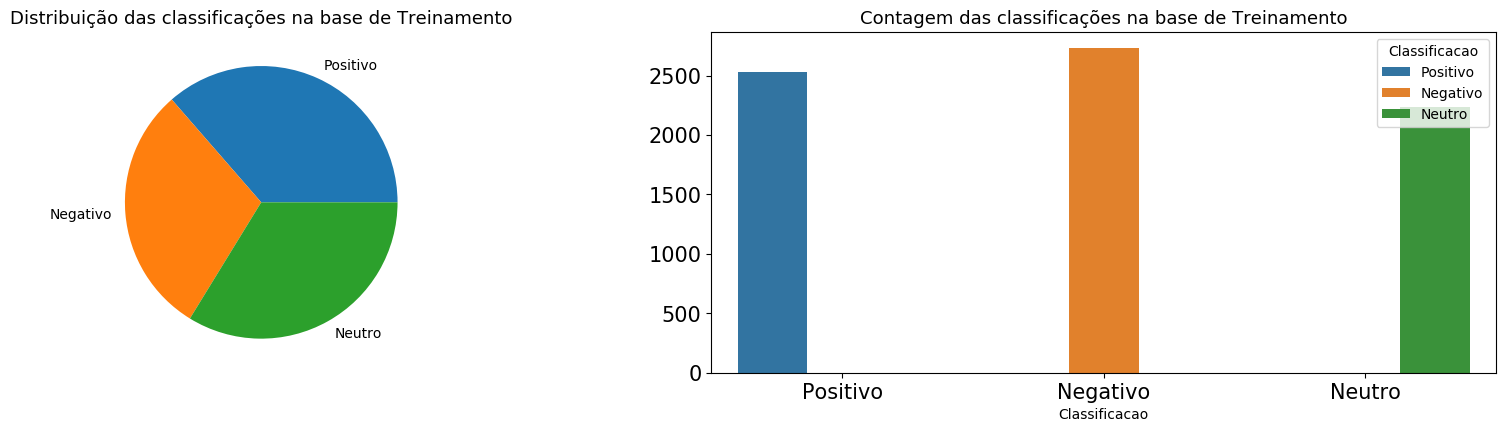

Negativo    2730
Positivo    2532
Neutro      2238
Name: Classificacao, dtype: int64

In [3]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('Classificacao').count()['Text'].plot(kind='pie', ax=axes[0], labels=['Positivo','Negativo', 'Neutro'])
sns.countplot(x=df_train['Classificacao'], hue=df_train['Classificacao'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Positivo','Negativo', 'Neutro'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Distribuição das classificações na base de Treinamento', fontsize=13)
axes[1].set_title('Contagem das classificações na base de Treinamento', fontsize=13)

plt.show()
df_train.Classificacao.value_counts()

## **Extração de informações**

* `cont_palavra` quantidade de palavras no texto
* `cont_palavra_unica` quantidade de palavras unicas no texto
* `stop_word_cont` quantidade de palavras que não implicam sentido na classificação
* `url_cont` contagem de links
* `media_tamanho_palavra` média do tamanho das palavras
* `cont_caracteres` quantidade de caracteres no texto
* `cont_pontuacao` quantidade de pontuações  no texto
* `cont_hashtags` quantidade de  hashtags (**#**) no texto
* `cont_mencao` quantidade de menções (**@**) no texto

In [4]:
df_train['cont_palavra'] = df_train['Text'].apply(lambda x: len(str(x).split()))
df_test['cont_palavra'] = df_test['Text'].apply(lambda x: len(str(x).split()))

df_train['cont_palavra_unica'] = df_train['Text'].apply(lambda x: len(set(str(x).split())))
df_test['cont_palavra_unica'] = df_test['Text'].apply(lambda x: len(set(str(x).split())))

df_train['stop_word_cont'] = df_train['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_cont'] = df_test['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

df_train['url_cont'] = df_train['Text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_cont'] = df_test['Text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

df_train['media_tamanho_palavra'] = df_train['Text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['media_tamanho_palavra'] = df_test['Text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

df_train['cont_caracteres'] = df_train['Text'].apply(lambda x: len(str(x)))
df_test['cont_caracteres'] = df_test['Text'].apply(lambda x: len(str(x)))

df_train['cont_pontuacao'] = df_train['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['cont_pontuacao'] = df_test['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df_train['cont_hashtags'] = df_train['Text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['cont_hashtags'] = df_test['Text'].apply(lambda x: len([c for c in str(x) if c == '#']))

df_train['cont_mencao'] = df_train['Text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['cont_mencao'] = df_test['Text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [5]:
df_train.head(3)

,Text,Classificacao,cont_palavra,cont_palavra_unica,stop_word_cont,url_cont,media_tamanho_palavra,cont_caracteres,cont_pontuacao,cont_hashtags,cont_mencao
0,Operação contra furto e roubo é realizada em P...,Positivo,13,13,4,2,7.307692,107,10,0,0
1,#vivoemrede #vivoon #vivosofrendo é patético o...,Negativo,17,16,6,0,5.352941,107,5,3,0
2,@claro me pasas el asterisco de corporativo po...,Neutro,9,9,3,0,5.000000,53,1,0,1


## **Distribuição dos atributos**

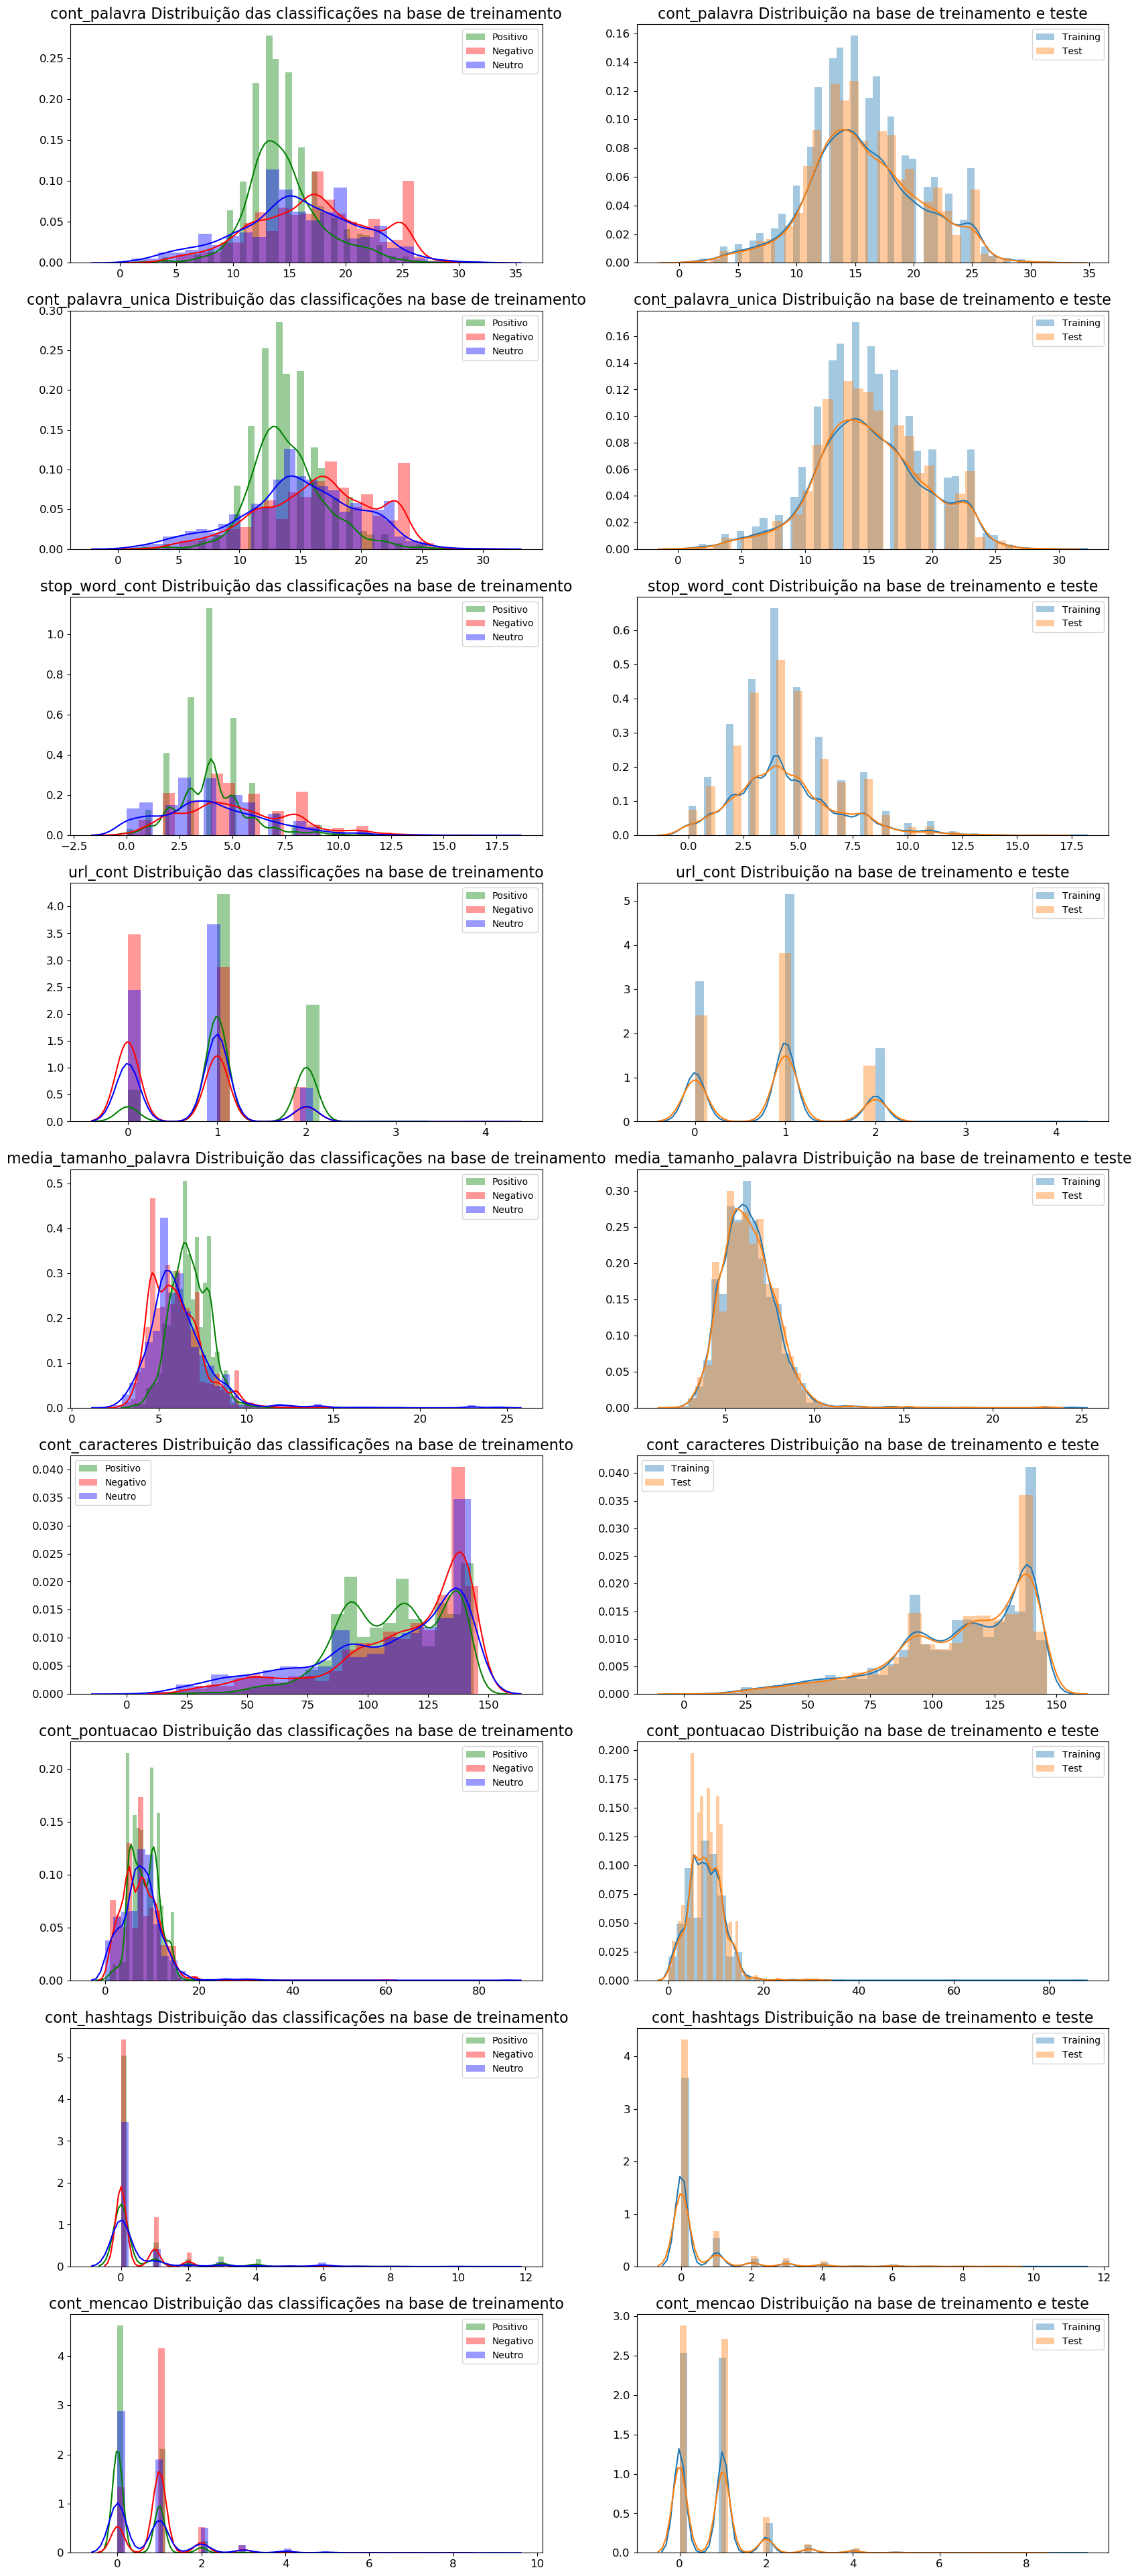

In [6]:
METAATRIBUTOS = ['cont_palavra', 'cont_palavra_unica', 'stop_word_cont', 'url_cont', 'media_tamanho_palavra',
                'cont_caracteres', 'cont_pontuacao', 'cont_hashtags', 'cont_mencao']

TWEETS_POSITIVOS = df_train['Classificacao'] == 'Positivo'
TWEETS_NEGATIVOS = df_train['Classificacao'] == 'Negativo'
TWEETS_NEUTROS = df_train['Classificacao'] == 'Neutro'

fig, axes = plt.subplots(ncols=2, nrows=len(METAATRIBUTOS), figsize=(20, 50), dpi=100)

for i, atributo in enumerate(METAATRIBUTOS):
    sns.distplot(df_train.loc[TWEETS_POSITIVOS][atributo], label='Positivo', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[TWEETS_NEGATIVOS][atributo], label='Negativo', ax=axes[i][0], color='red')
    sns.distplot(df_train.loc[TWEETS_NEUTROS][atributo], label='Neutro', ax=axes[i][0], color='blue')
    
    sns.distplot(df_train[atributo], label='Training', ax=axes[i][1])
    sns.distplot(df_test[atributo], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{atributo} Distribuição das classificações na base de treinamento', fontsize=16)
    axes[i][1].set_title(f'{atributo} Distribuição na base de treinamento e teste', fontsize=16)

plt.show()

## **Trabalhando com N-grams**

In [7]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
POSITIVOS_unigrams = defaultdict(int)
NEGATIVOS_unigrams = defaultdict(int)
NEUTROS_unigrams = defaultdict(int)

for tweet in df_train[TWEETS_POSITIVOS]['Text']:
    for palavra in generate_ngrams(tweet):
        POSITIVOS_unigrams[palavra] += 1
        
for tweet in df_train[TWEETS_NEGATIVOS]['Text']:
    for palavra in generate_ngrams(tweet):
        NEGATIVOS_unigrams[palavra] += 1
        
for tweet in df_train[TWEETS_NEUTROS]['Text']:
    for palavra in generate_ngrams(tweet):
        NEUTROS_unigrams[palavra] += 1
        
df_POSITIVOS_unigrams = pd.DataFrame(sorted(POSITIVOS_unigrams.items(), key=lambda x: x[1])[::-1])
df_NEGATIVOS_unigrams = pd.DataFrame(sorted(NEGATIVOS_unigrams.items(), key=lambda x: x[1])[::-1])
df_NEUTROS_unigrams = pd.DataFrame(sorted(NEUTROS_unigrams.items(), key=lambda x: x[1])[::-1])


# Bigrams
POSITIVOS_bigrams = defaultdict(int)
NEGATIVOS_bigrams = defaultdict(int)
NEUTROS_bigrams = defaultdict(int)


for tweet in df_train[TWEETS_POSITIVOS]['Text']:
    for word in generate_ngrams(tweet, n_gram=2):
        POSITIVOS_bigrams[word] += 1
        
for tweet in df_train[TWEETS_NEGATIVOS]['Text']:
    for word in generate_ngrams(tweet, n_gram=2):
        NEGATIVOS_bigrams[word] += 1
        
for tweet in df_train[TWEETS_NEUTROS]['Text']:
    for word in generate_ngrams(tweet, n_gram=2):
        NEUTROS_bigrams[word] += 1
        
df_POSITIVOS_bigrams = pd.DataFrame(sorted(POSITIVOS_bigrams.items(), key=lambda x: x[1])[::-1])
df_NEGATIVOS_bigrams = pd.DataFrame(sorted(NEGATIVOS_bigrams.items(), key=lambda x: x[1])[::-1])
df_NEUTROS_bigrams = pd.DataFrame(sorted(NEUTROS_bigrams.items(), key=lambda x: x[1])[::-1])


# Trigrams
POSITIVOS_trigrams = defaultdict(int)
NEGATIVOS_trigrams = defaultdict(int)
NEUTROS_trigrams = defaultdict(int)

for tweet in df_train[TWEETS_POSITIVOS]['Text']:
    for word in generate_ngrams(tweet, n_gram=3):
        POSITIVOS_trigrams[word] += 1
        
for tweet in df_train[TWEETS_NEGATIVOS]['Text']:
    for word in generate_ngrams(tweet, n_gram=3):
        NEGATIVOS_trigrams[word] += 1

for tweet in df_train[~TWEETS_NEUTROS]['Text']:
    for word in generate_ngrams(tweet, n_gram=3):
        NEUTROS_trigrams[word] += 1
        
df_POSITIVOS_trigrams = pd.DataFrame(sorted(POSITIVOS_trigrams.items(), key=lambda x: x[1])[::-1])
df_NEGATIVOS_trigrams = pd.DataFrame(sorted(NEGATIVOS_trigrams.items(), key=lambda x: x[1])[::-1])
df_NEUTROS_trigrams = pd.DataFrame(sorted(NEUTROS_trigrams.items(), key=lambda x: x[1])[::-1])

### **Unigrams**


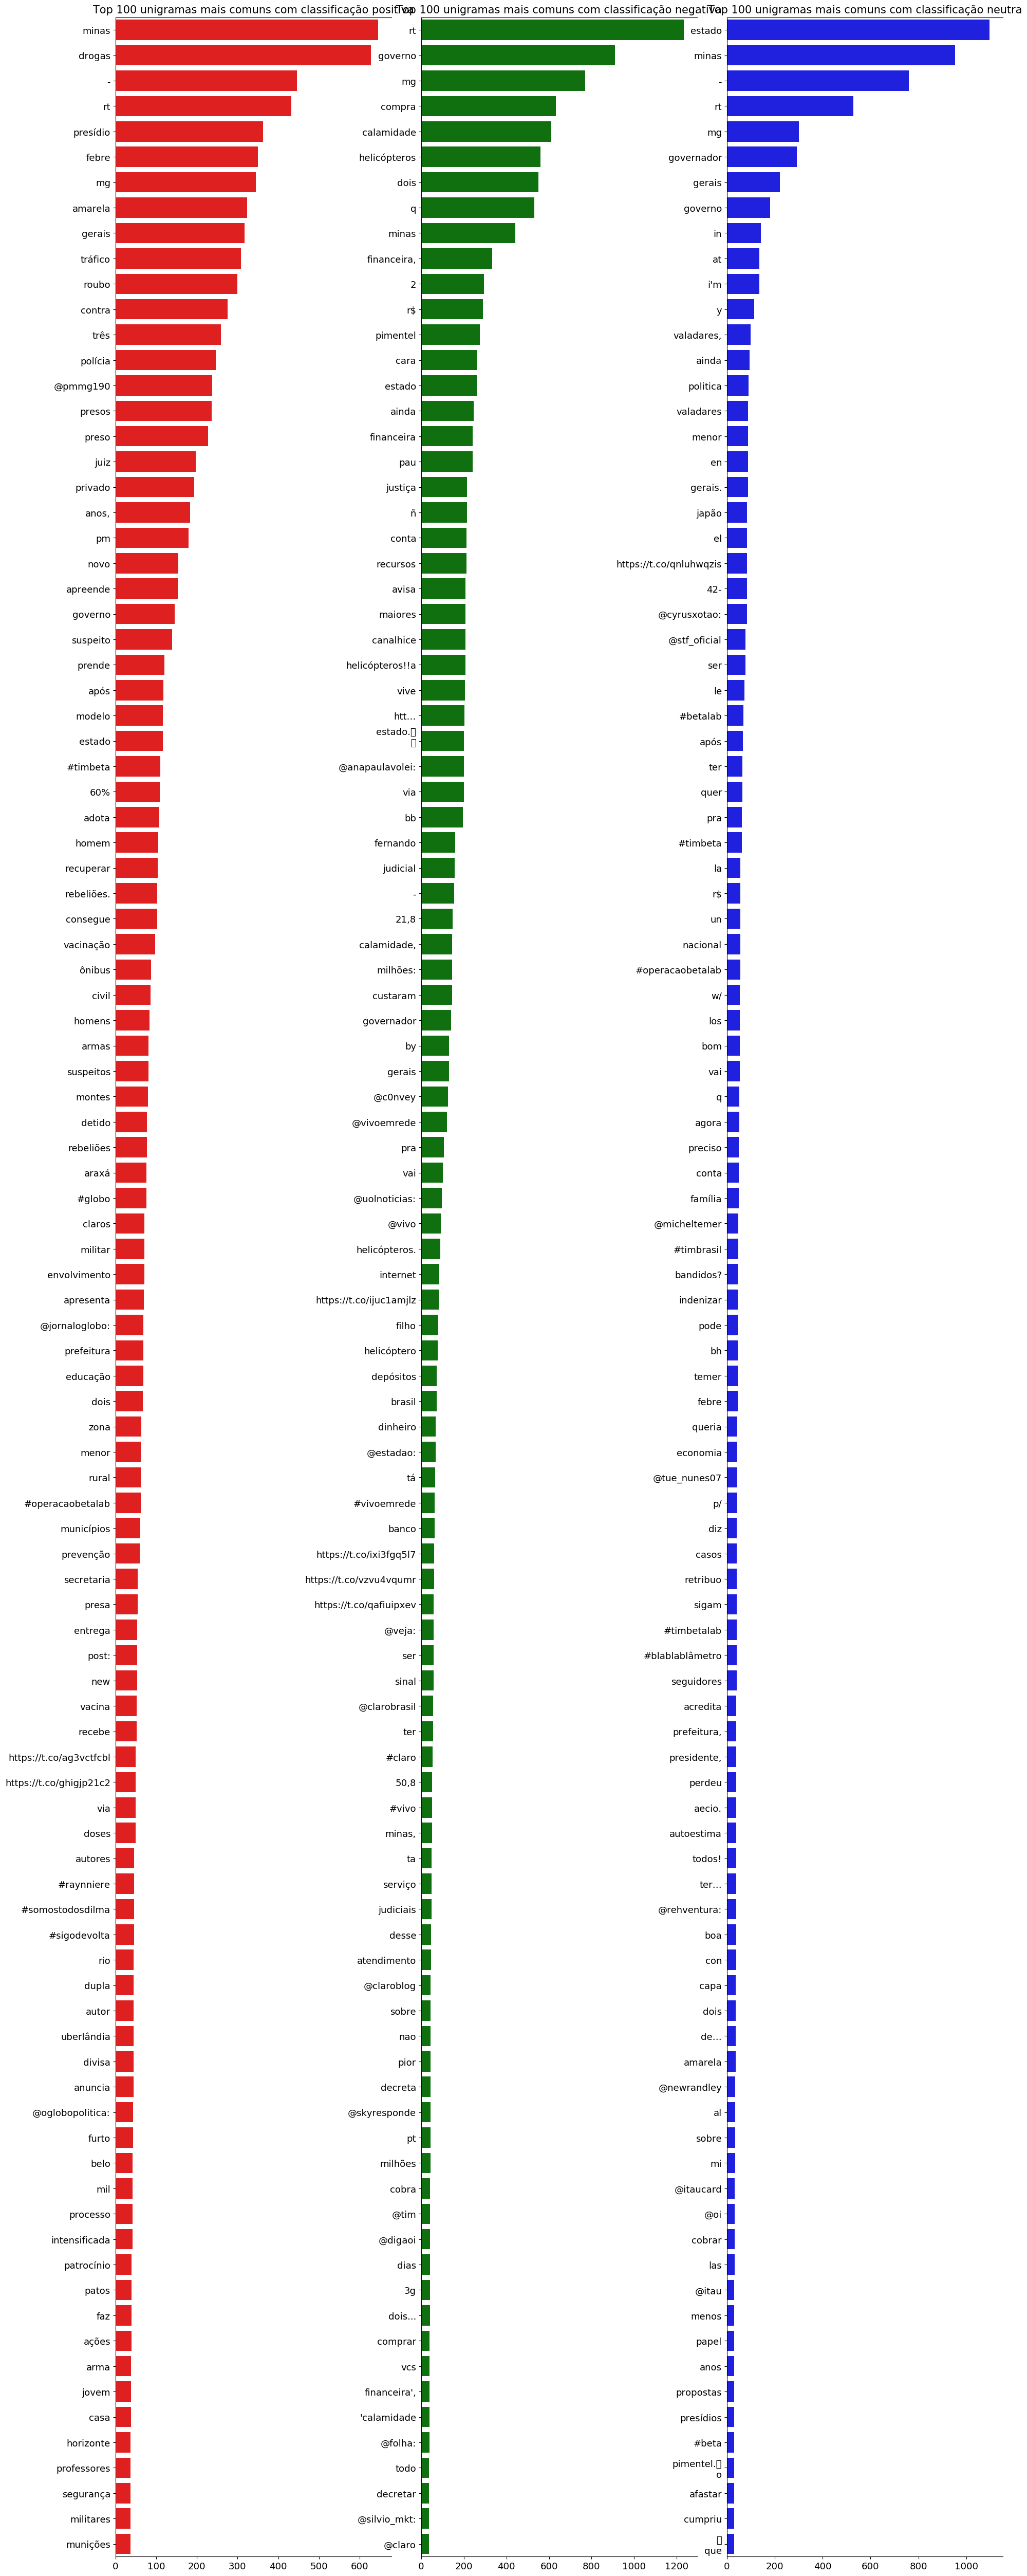

In [78]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 50), dpi=100)
plt.tight_layout()
sns.barplot(y=df_POSITIVOS_unigrams[0].values[:N], x=df_POSITIVOS_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_NEGATIVOS_unigrams[0].values[:N], x=df_NEGATIVOS_unigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=df_NEUTROS_unigrams[0].values[:N], x=df_NEUTROS_unigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} unigramas mais comuns com classificação positiva', fontsize=15)
axes[1].set_title(f'Top {N} unigramas mais comuns com classificação negativa', fontsize=15)
axes[2].set_title(f'Top {N} unigramas mais comuns com classificação neutra', fontsize=15)

plt.show()

### **Bigrams**


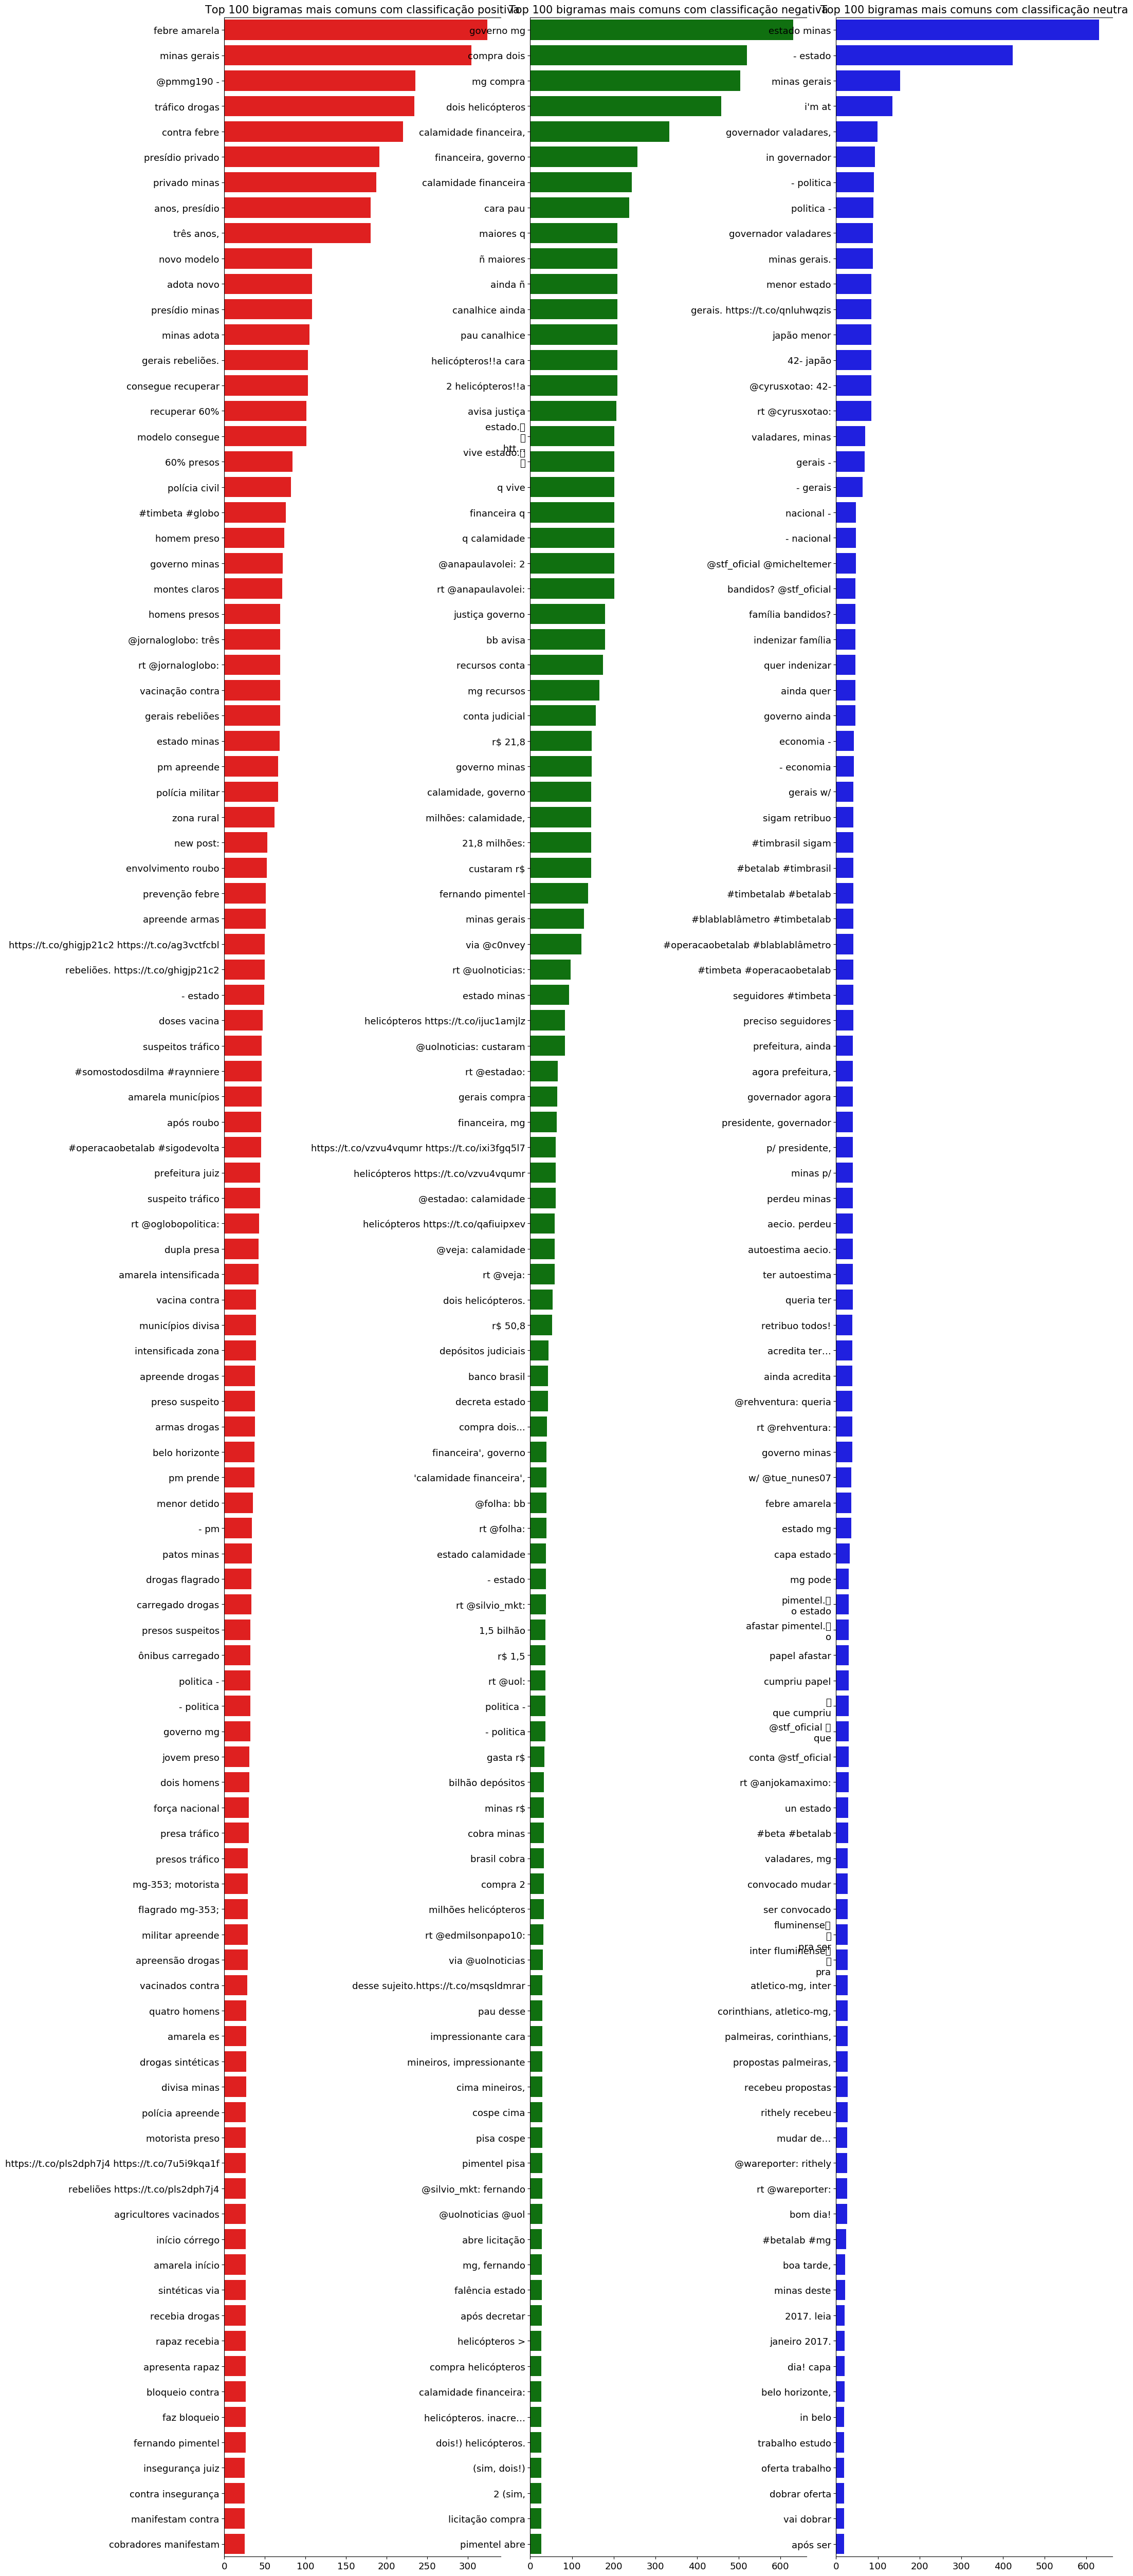

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 50), dpi=100)
plt.tight_layout()
sns.barplot(y=df_POSITIVOS_bigrams[0].values[:N], x=df_POSITIVOS_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_NEGATIVOS_bigrams[0].values[:N], x=df_NEGATIVOS_bigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=df_NEUTROS_bigrams[0].values[:N], x=df_NEUTROS_bigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} bigramas mais comuns com classificação positiva', fontsize=15)
axes[1].set_title(f'Top {N} bigramas mais comuns com classificação negativa', fontsize=15)
axes[2].set_title(f'Top {N} bigramas mais comuns com classificação neutra', fontsize=15)

plt.show()

### **Trigrams**


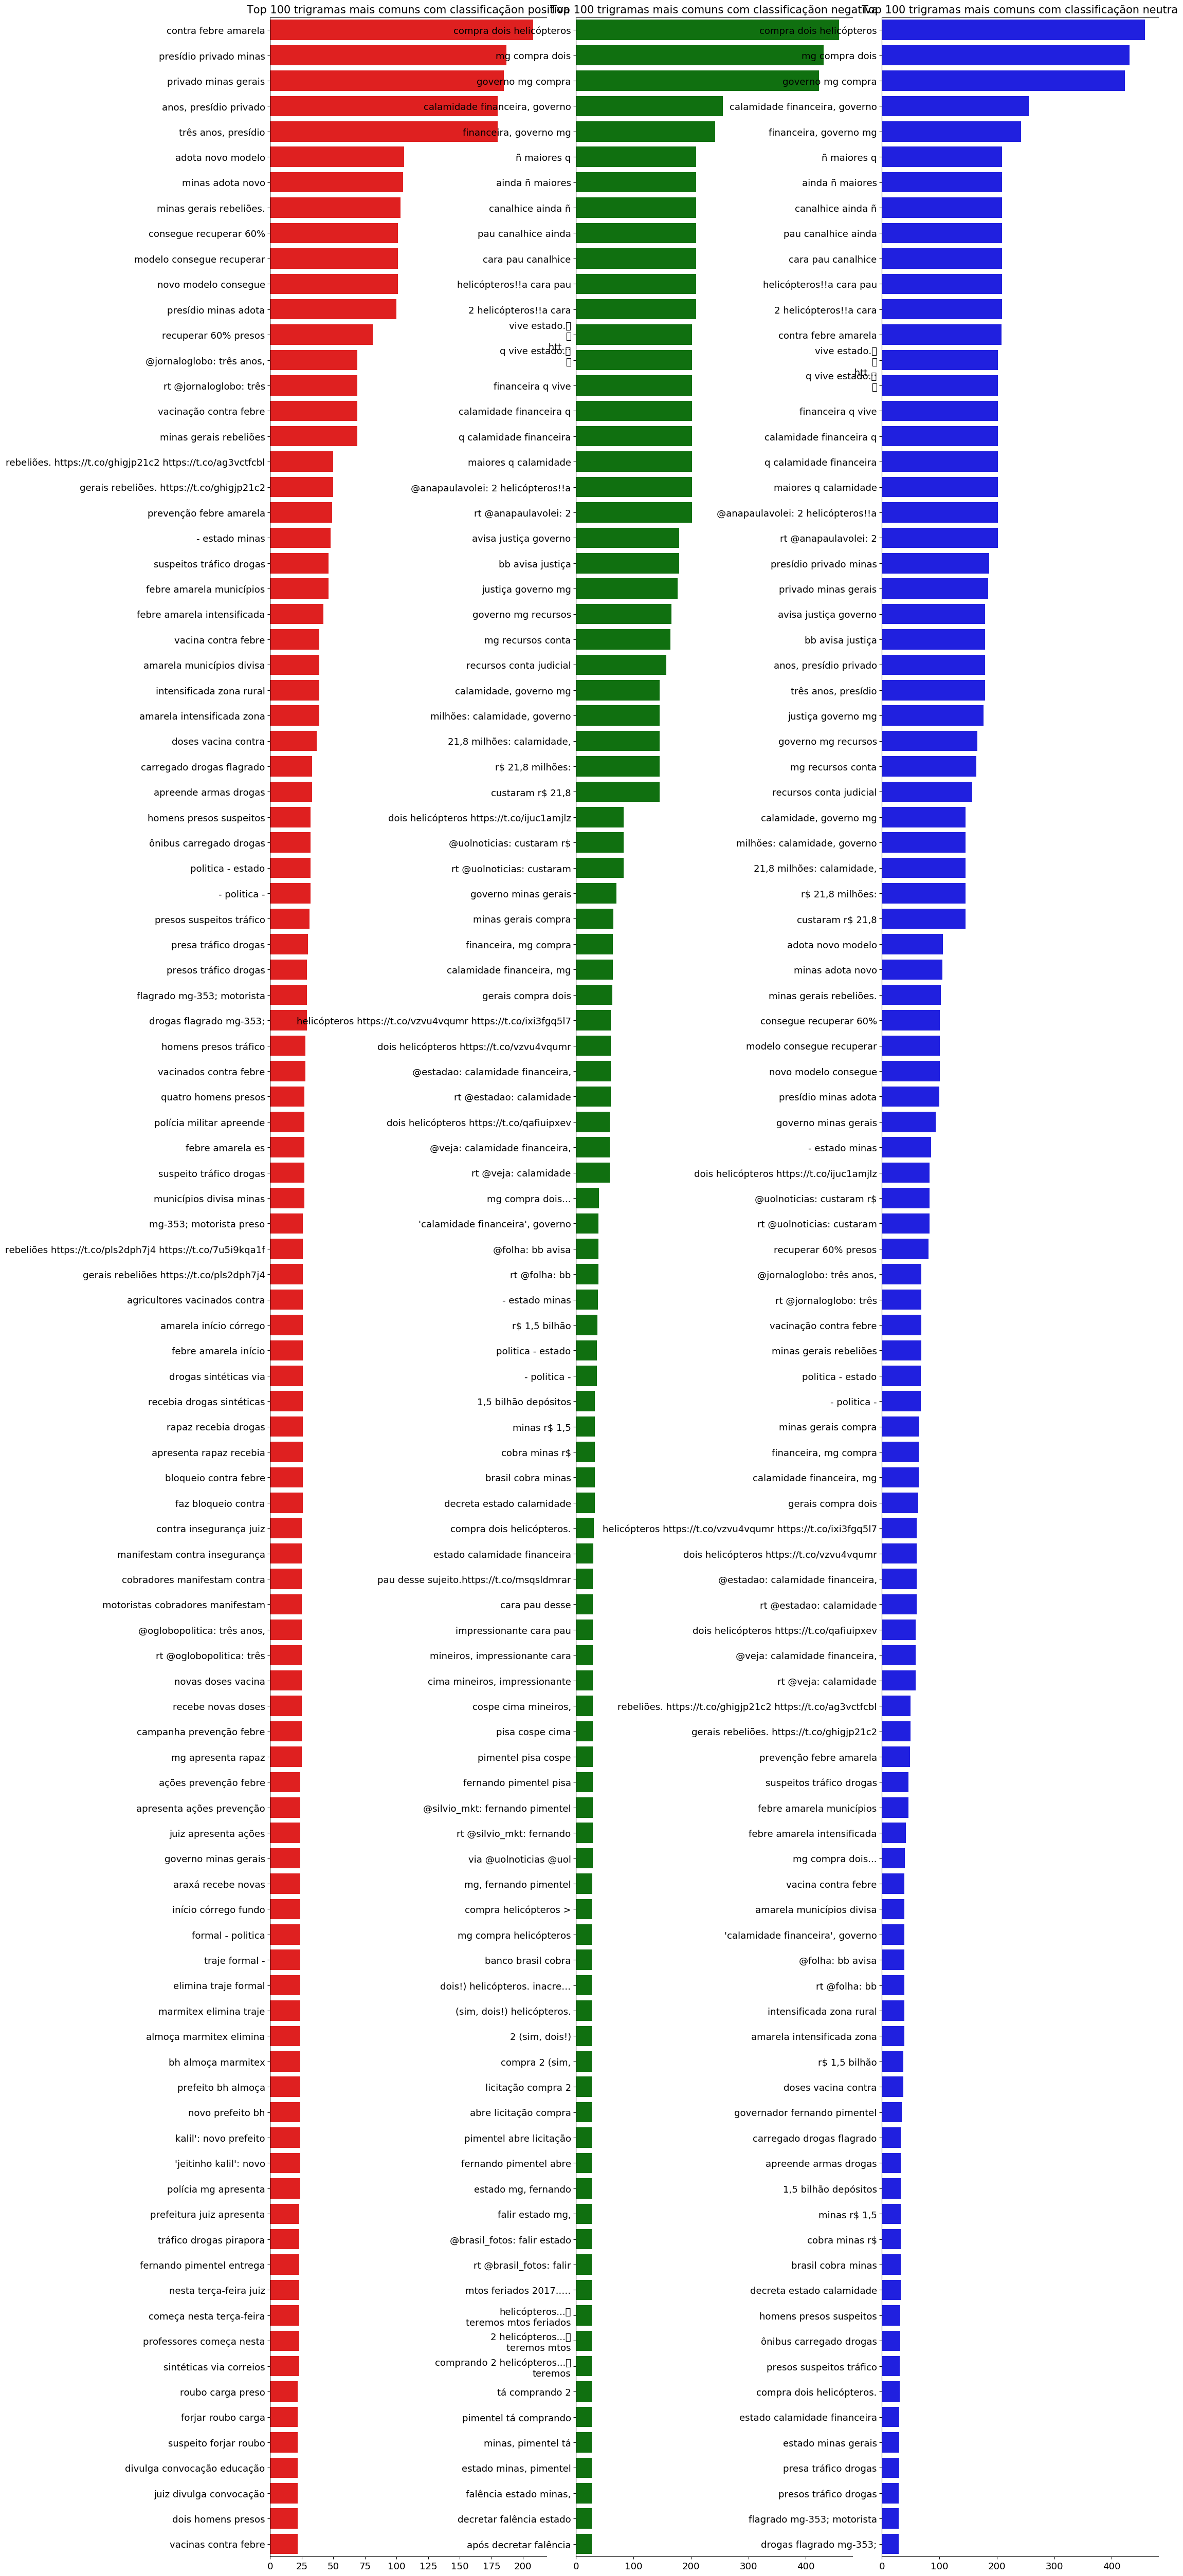

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 50), dpi=100)
plt.tight_layout()
sns.barplot(y=df_POSITIVOS_trigrams[0].values[:N], x=df_POSITIVOS_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_NEGATIVOS_trigrams[0].values[:N], x=df_NEGATIVOS_trigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=df_NEUTROS_trigrams[0].values[:N], x=df_NEUTROS_trigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} trigramas mais comuns com classificaçãon positiva', fontsize=15)
axes[1].set_title(f'Top {N} trigramas mais comuns com classificaçãon negativa', fontsize=15)
axes[2].set_title(f'Top {N} trigramas mais comuns com classificaçãon neutra', fontsize=15)

plt.show()

### **Pré-processamento do texto**


In [11]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_link(text):
    return re.sub(r"http\S+", "", text)

def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

def Limpeza_dados(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

def Preprocessing(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))


In [12]:
df_uniao = pd.concat([df_train, df_test])
df_uniao["Text"] = df_uniao["Text"].apply(remove_emoji)
df_uniao["Text"] = df_uniao["Text"].apply(remove_link)
df_uniao["Text"] = df_uniao["Text"].apply(Preprocessing)

In [13]:
df_train.head(3)

,Text,Classificacao,cont_palavra,cont_palavra_unica,stop_word_cont,url_cont,media_tamanho_palavra,cont_caracteres,cont_pontuacao,cont_hashtags,cont_mencao
0,Operação contra furto e roubo é realizada em P...,Positivo,13,13,4,2,7.307692,107,10,0,0
1,#vivoemrede #vivoon #vivosofrendo é patético o...,Negativo,17,16,6,0,5.352941,107,5,3,0
2,@claro me pasas el asterisco de corporativo po...,Neutro,9,9,3,0,5.000000,53,1,0,1


In [14]:
df_uniao.head(3)

,Text,Classificacao,cont_palavra,cont_palavra_unica,stop_word_cont,url_cont,media_tamanho_palavra,cont_caracteres,cont_pontuacao,cont_hashtags,cont_mencao
0,oper contr furt roub realiz pat min,Positivo,13,13,4,2,7.307692,107,10,0,0
1,#vivoemred #vivoon #vivosofr paté númer protoc...,Negativo,17,16,6,0,5.352941,107,5,3,0
2,@clar pas el asterisc corpor favor,Neutro,9,9,3,0,5.000000,53,1,0,1


In [15]:
classes = pd.DataFrame(df_uniao.Classificacao)
previsores = df_uniao.drop(['Text','Classificacao'], 1)
vectorizer = CountVectorizer(analyzer='word')
freq = vectorizer.fit_transform(df_uniao['Text'])
vetor = pd.DataFrame(freq.toarray())
previsores[list(vetor.columns.values)]= vetor

In [16]:
from sklearn.model_selection import train_test_split
X_base_treinamento, X_base_teste,y_base_treinamento,y_base_teste = train_test_split(previsores,classes,test_size=0.3)

### **Avaliação de modelos e Resultados**

In [ ]:

def modelos (clas=None):
    inicio =time.time()
    metricas = []
    for i in clas:
        try:
            pipeline_simples = Pipeline([
              #('counts', CountVectorizer()),
              ('classifier', eval(str(i+"()")))
            ])
            pipeline_simples.fit(X_base_treinamento,y_base_treinamento.values.ravel())
            pipeline_simples.steps
            resultados = cross_val_predict(pipeline_simples, X_base_teste, y_base_teste, cv=2)
            metricas.append((str(i),metrics.accuracy_score(y_base_teste,resultados),round(time.time() - inicio,3)))
            print(str(i) ,' : ',metrics.accuracy_score(y_base_teste,resultados), ' : ',round(time.time() - inicio,3),'Seg.')
        except Exception as e:
            pass
    return metricas
classificadores = modelos([ 'DecisionTreeClassifier',
                            'GradientBoostingClassifier',
                            'KNeighborsClassifier',
                            'LogisticRegression',
                            'SGDClassifier',
                            'SVC',
                            'BernoulliNB',
                            'GaussianNB',
                            'MultinomialNB',
                            'VotingClassifier',
                            'RandomForestClassifier',
                            'CalibratedClassifierCV'])
classificadores

In [74]:
classificadores2 = [(j,i) for i,j,k in classificadores]
classificadores2

[(0.7110419906687403, 'DecisionTreeClassifier'),
 (0.7418351477449455, 'GradientBoostingClassifier'),
 (0.6681181959564542, 'KNeighborsClassifier'),
 (0.6982892690513219, 'LogisticRegression'),
 (0.5287713841368584, 'SGDClassifier'),
 (0.49020217729393467, 'SVC'),
 (0.6786936236391913, 'BernoulliNB'),
 (0.5094867807153965, 'GaussianNB'),
 (0.6662519440124417, 'MultinomialNB'),
 (0.7409020217729394, 'RandomForestClassifier'),
 (0.7303265940902022, 'CalibratedClassifierCV')]

<function matplotlib.pyplot.show(*args, **kw)>

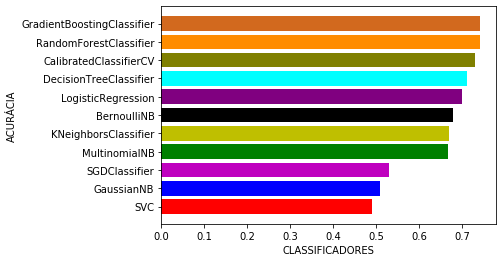

In [73]:
x = [j for i,j in sorted(classificadores2)]
y = [i for i,j in sorted(classificadores2)]
plt.barh(x,y, color=["r",'b','m','g','y','k','purple','cyan','olive','darkorange','chocolate'])
plt.xlabel("CLASSIFICADORES")
plt.ylabel("ACURÁCIA")
plt.show

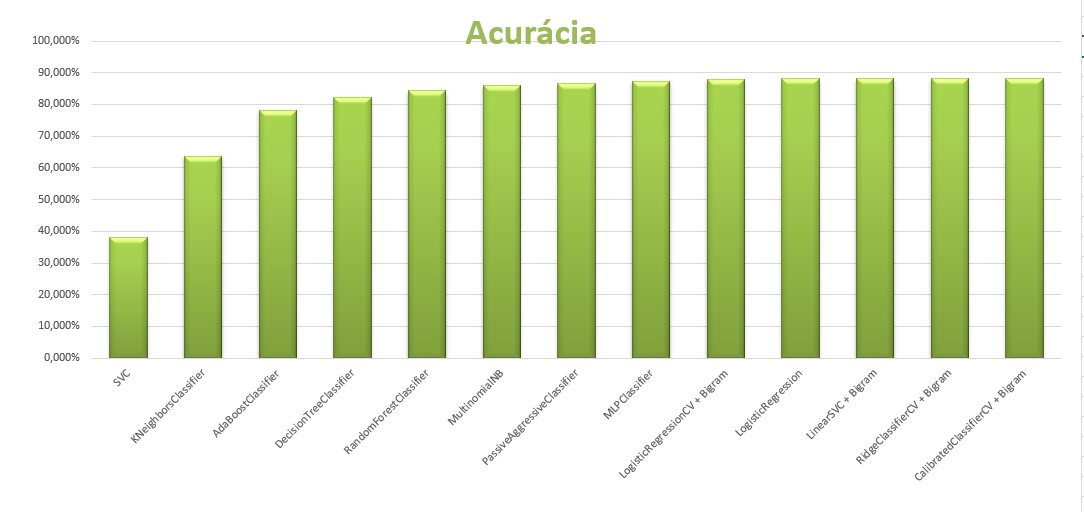

In [75]:
from IPython.display import display, Image
display(Image(filename='results.png'))